In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
# This function basically returns all the images inside the directory as well as their labels either as "PNEUMONIA" or "NORMAL"
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
# Now import the three sets of data
train = get_training_data(r'C:\Users\mliu0\Desktop\archive\chest_xray\train')
test = get_training_data(r'C:\Users\mliu0\Desktop\archive\chest_xray\test')
val = get_training_data(r'C:\Users\mliu0\Desktop\archive\chest_xray\val')

c:\users\mliu0\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


c:\users\mliu0\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


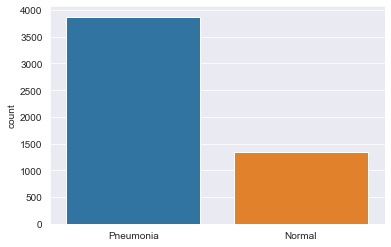

In [7]:
# Data Visualization
lst = []
for i in train:
    if (i[1] == 0):
        lst.append("Pneumonia")
    else:
        lst.append("Normal")
sns.set_style('darkgrid')
sns.countplot(lst)

Text(0.5, 1.0, 'NORMAL')

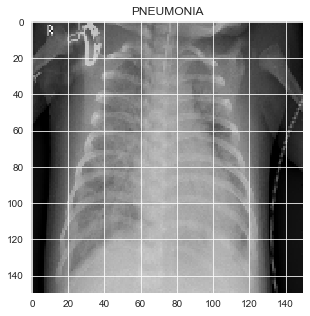

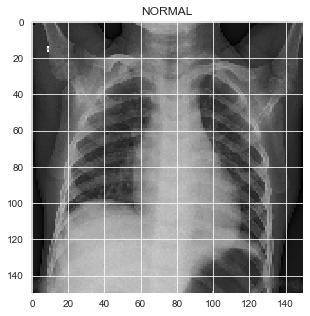

In [8]:
# Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [9]:
# OK Here I am Setting up some lists
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [10]:
# We perform a grayscale normalization to reduce the effect of illumination's differences
# Since the image is stored in grascale values, we can just divide everything by 255. 
# So now the values are all between 0 and 1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [11]:
# Now resize the data
# The x is a four dimentional array
 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
'''Data augmentation: alter the training data by changing the array without changing its lable
This is used to expand the data set in order to avoid overfitting of the data
Ways to alter: 
Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset.'''

#Use Keras ImageDataGenerator class.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


In [14]:
#Keras Sqeuntial Model
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
#Compile the sequential model
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 64)       

In [15]:
# Reduce learning rate when the validation accuracy has stopped improvin after two epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [16]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 286s 2s/step - loss: 1.0456 - accuracy: 0.7664 - val_loss: 28.5676 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 318s 2s/step - loss: 0.2712 - accuracy: 0.8830 - val_loss: 59.0924 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 325s 2s/step - loss: 0.2494 - accuracy: 0.9095 - val_loss: 31.9838 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 281s 2s/step - loss: 0.1629 - accuracy: 0.9412 - val_loss: 0.7118 - val_accuracy: 0.7500
Epoch 5/12
163/163 [==============================] - 334s 2s/step - loss: 0.1289 - accuracy: 0.9535 - val_loss: 0.4129 - val_accuracy: 0.8750
Epoch 6/12
163/163 [==============================] - 307s 2s/step - loss: 0.1298 - accuracy: 0.9494 - val_loss: 82.4787 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 326

In [17]:
# WHAT IS HAPPENING WITH THE VALIDATION ACCURACY I AM SO CONFUSED WHY DOES IT STAY AT 50 PERCENT AND NOT GOING UP?
# ARE WE OVERFITTING THE DATA??
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 188ms/step - loss: 0.3207 - accuracy: 0.9103
Loss of the model is -  0.320712685585022
20/20 [==============================] - 5s 272ms/step - loss: 0.3207 - accuracy: 0.9103
Accuracy of the model is -  91.02563858032227 %


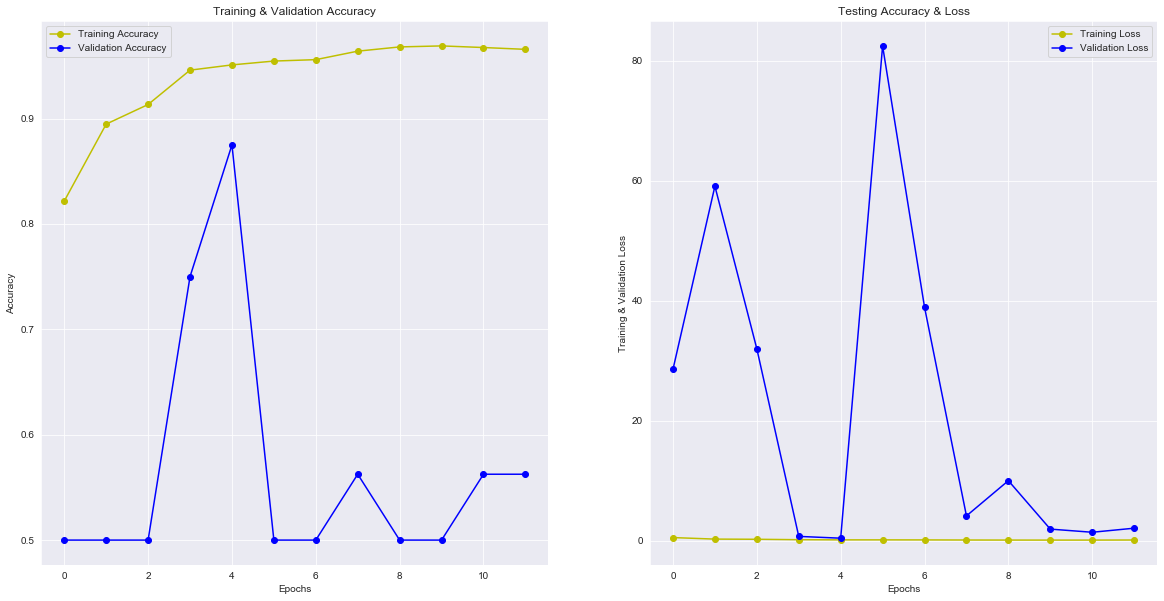

In [20]:
# Plot plot plot :)
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'yo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'bo-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'y-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'b-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [21]:
# Now predict using the test set.
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

C:\Users\mliu0\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [22]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [23]:
# Build a confusion matrix
cm = confusion_matrix(y_test,predictions)
cm

array([[362,  28],
       [ 28, 206]], dtype=int64)

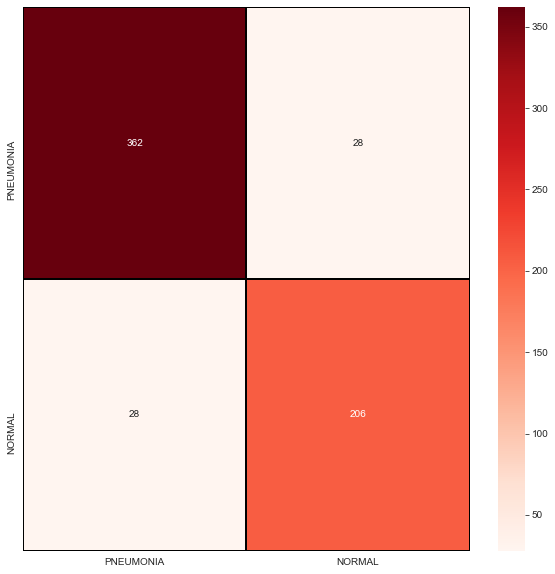

In [24]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

# Now visualize the confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [26]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

print("Correct predictions: ", len(correct))
print("Incorrect predictions: ", len(incorrect))

Correct predictions:  568
Incorrect predictions:  56
